In [6]:
import numpy as np 
from scipy.stats import kruskal, f_oneway, median_test
from collections import defaultdict


## Implementation of the Shapelet Generation

Here is the original pseudo code from the paper : 

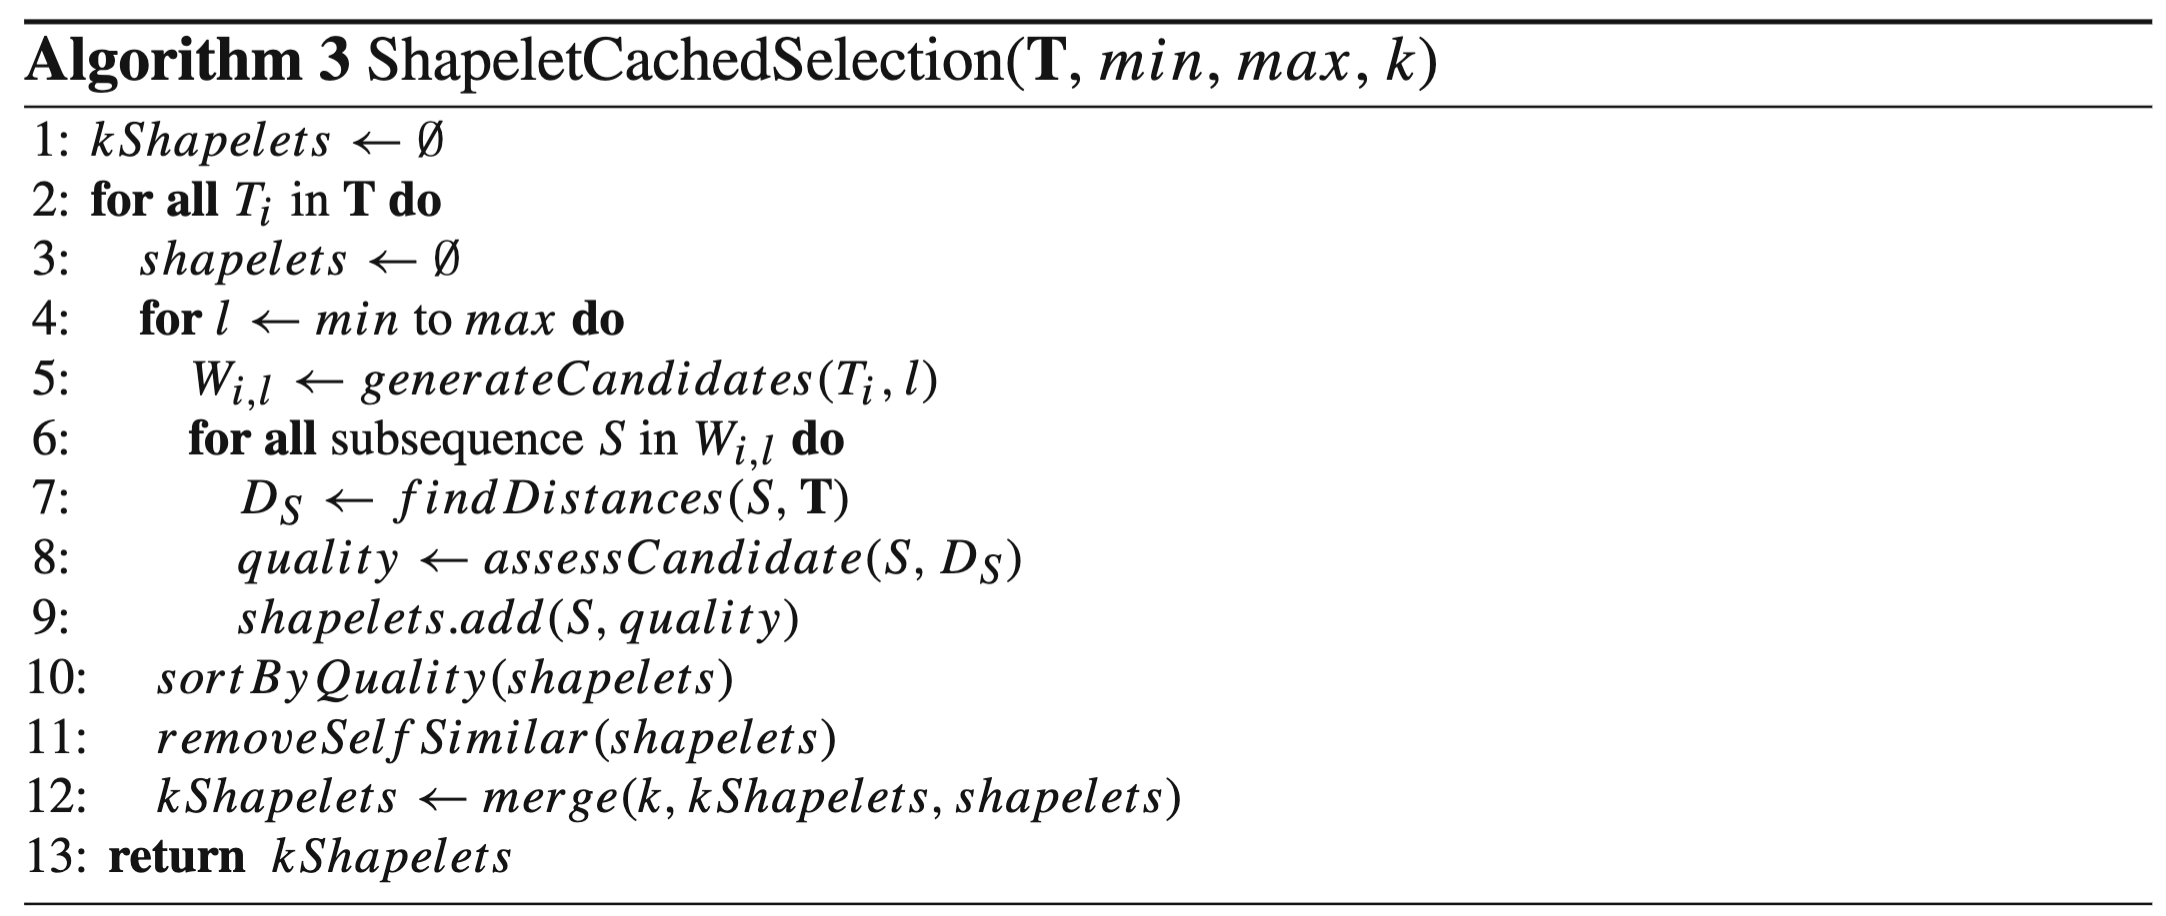

### Utils for handling shapelet data

In [7]:
from dataclasses import dataclass

@dataclass
class Shapelet:
    series_id: int
    start: int
    length: int
    quality: float
    data: any = None  # optionnel


In [8]:
def generateCandidates(t_i,l) :
    """
    Generate m-l+1 shapelet candidates 
    """
    W_i_l = []
    m = t_i.shape[0]
    for j in range(m-l+1) : 
        candidate = t_i[j:j+l]
        W_i_l.append(candidate)
    return W_i_l

In [9]:
def euclidean_distance(x,y) : 
    return np.sum((x-y)**2)

def z_normalize(x, eps=1e-8):
    mu = np.mean(x)
    sigma = np.std(x)
    if sigma < eps:
        return np.zeros_like(x)
    return (x - mu) / sigma

def findDistances(T, S):
    """
    T : array (n_series, series_length)
    S : array (l,)
    """
    n = T.shape[0]
    l = S.shape[0]
    D_W = np.zeros(n)
    S_norm = z_normalize(S)

    for i, t in enumerate(T):
        m = t.shape[0]
        min_dist = np.inf
        for j in range(m - l + 1):
            sub_t = t[j:j+l]
            sub_t_norm = z_normalize(sub_t)
            dist = euclidean_distance(sub_t_norm,S_norm)
            if dist < min_dist:
                min_dist = dist
        D_W[i] = min_dist

    return D_W


### Utils for assessing the quality of the shapelets

In [ ]:
def split_by_class(D_S, y):
    """
    Return a dict {class: np.array(distances)}
    """
    groups = defaultdict(list)
    for d, label in zip(D_S, y):
        groups[label].append(d)
    return {k: np.array(v) for k, v in groups.items()}

def information_gain(D_S, y):
    """
    Information Gain computation for all different splits
    """
    D_S = np.asarray(D_S)
    y = np.asarray(y)

    order = np.argsort(D_S)
    D_sorted = D_S[order]
    y_sorted = y[order]

    def entropy(labels):
        _, counts = np.unique(labels, return_counts=True)
        probs = counts / counts.sum()
        return -np.sum(probs * np.log2(probs + 1e-12))

    base_entropy = entropy(y_sorted)
    best_ig = 0.0

    for i in range(1, len(D_sorted)):
        left = y_sorted[:i]
        right = y_sorted[i:]
        ig = base_entropy
        ig -= (len(left) / len(y)) * entropy(left)
        ig -= (len(right) / len(y)) * entropy(right)
        best_ig = max(best_ig, ig)

    return best_ig

def f_statistic(D_S, y):
    """
    ANOVA F-statistic 
    """
    groups = split_by_class(D_S, y)
    if len(groups) < 2:
        return 0.0
    return f_oneway(*groups.values()).statistic

def kruskal_wallis(D_S, y):
    """
    Test of Kruskal-Wallis 
    """
    groups = split_by_class(D_S, y)
    if len(groups) < 2:
        return 0.0
    return kruskal(*groups.values()).statistic

def moods_median(D_S, y):
    """
    Mood's median test (statistique du test)
    """
    groups = split_by_class(D_S, y)
    if len(groups) < 2:
        return 0.0
    stat, _, _, _ = median_test(*groups.values())
    return stat

def assessCandidate(D_S, y, method="f_stat"):
    """
    Wrapper function to asses the quality of a shapelet 
    method : {"f_stat", "ig", "kruskal", "median"}
    """
    if method == "f_stat":
        return f_statistic(D_S, y)
    elif method == "ig":
        return information_gain(D_S, y)
    elif method == "kruskal":
        return kruskal_wallis(D_S, y)
    elif method == "median":
        return moods_median(D_S, y)
    else:
        raise ValueError(f"Méthode inconnue : {method}")


In [ ]:
def sort_by_quality(shapelets, reverse=True):
    """
    Sort the shapelet by their quality 

    shapelets : liste of tuples (shapelet, quality)
    reverse   : True = best quality in first position
    """
    return sorted(shapelets, key=lambda x: x.quality, reverse=reverse)



In [ ]:
def overlaps(s1, s2):
    """
    Check if two shapelets does overlap
    """
    end1 = s1.start + s1.length - 1
    end2 = s2.start + s2.length - 1
    return not (end1 < s2.start or end2 < s1.start)


def remove_self_similar(shapelets):
    """
    - shapelets : list(Shapelet) 
    - shapelets is already ordered by decreasing quality
    """
    filtered = []

    for s in shapelets:
        keep = True
        for kept in filtered:
            if s.series_id == kept.series_id and overlaps(s, kept):
                keep = False
                break
        if keep:
            filtered.append(s)

    return filtered


In [27]:
def merge(k, k_shapelets, new_shapelets):
    """
    Merge the new shapelets with the old ones and keep the k best 

    Parameters
    ----------
    k : int
        max number of shapelets to keep
    k_shapelets : list[Shapelet]
        old shapelets 
    new_shapelets : list[Shapelet]
        New shapelets 

    Returns 
    ------
    list[Shapelet]
        top-k shapelets sorted by decreasing quality
    """
    merged = k_shapelets + new_shapelets
    merged.sort(key=lambda s: s.quality, reverse=True)
    return merged[:k]

In [ ]:
def ShapeletCachedSelection(
    T,
    y,
    min_len,
    max_len,
    k,
    quality_method="f_stat"
):
    """
    Implementation of the algorithm 3 

    Parameters : 
    ----------
    T : np.ndarray (n_series, series_length)
        Dataset of time series
    y : np.ndarray (n_series,)
        Labels 
    min_len : int
        minimum lenght of the shapelets 
    max_len : int
        maximum lenght of the shapelets
    k : int
        Number of Shapelets kept 
    quality_method : str
        {"f_stat", "ig", "kruskal", "median"}

    Returns : 
    ------
    list[Shapelet]
        containing the k best Shapelets 
    """
    n_series, series_length = T.shape
    kShapelets = []  
    for series_id in range(n_series):
        t = T[series_id]
        shapelets = []  
        for l in range(min_len, max_len + 1):
            if l > series_length:
                continue
            for start in range(series_length - l + 1):
                S = t[start:start + l]
                D_S = findDistances(T, S)
                quality = assessCandidate(D_S, y, method=quality_method)
                shapelets.append(
                    Shapelet(
                        series_id=series_id,
                        start=start,
                        length=l,
                        quality=quality,
                        data=S
                    )
                )
        shapelets = sort_by_quality(shapelets)
        shapelets = remove_self_similar(shapelets)
        kShapelets = merge(k, kShapelets, shapelets)

    return kShapelets


In [15]:
def EstimateMinAndMax() :
    pass   

## Sanity Check with toy dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

def generate_synthetic_dataset(
    n_series=20,
    series_length=100,
    shapelet_length=15
):
    X = np.random.normal(0, 1, (n_series, series_length))
    y = np.zeros(n_series, dtype=int)

    # shapelets for each class
    shapelet_A = np.sin(np.linspace(0, np.pi, shapelet_length))
    shapelet_B = -shapelet_A

    for i in range(n_series):
        pos = np.random.randint(0, series_length - shapelet_length)
        if i < n_series // 2:
            X[i, pos:pos+shapelet_length] += shapelet_A
            y[i] = 0
        else:
            X[i, pos:pos+shapelet_length] += shapelet_B
            y[i] = 1

    return X, y, shapelet_A, shapelet_B


X, y, true_A, true_B = generate_synthetic_dataset()


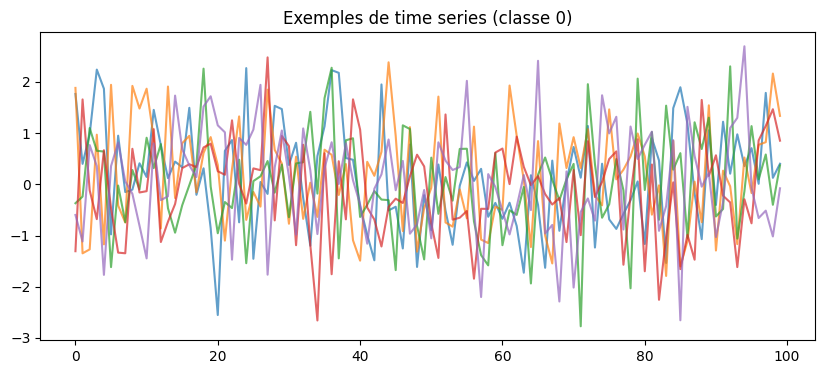

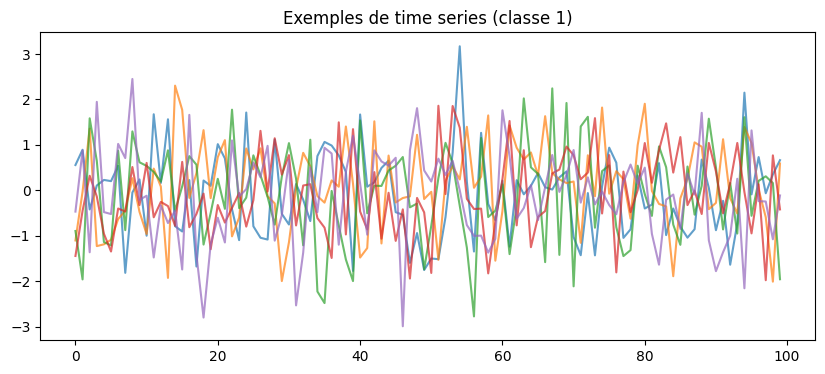

In [18]:
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.plot(X[i], alpha=0.7)
plt.title("Exemples de time series (classe 0)")
plt.show()

plt.figure(figsize=(10, 4))
for i in range(10, 15):
    plt.plot(X[i], alpha=0.7)
plt.title("Exemples de time series (classe 1)")
plt.show()


Shapelets sélectionnés :
series=10, start=80, len=10, quality=19.907
series=12, start=2, len=13, quality=16.448
series=6, start=13, len=12, quality=15.941
series=15, start=45, len=11, quality=14.462
series=13, start=47, len=10, quality=12.174


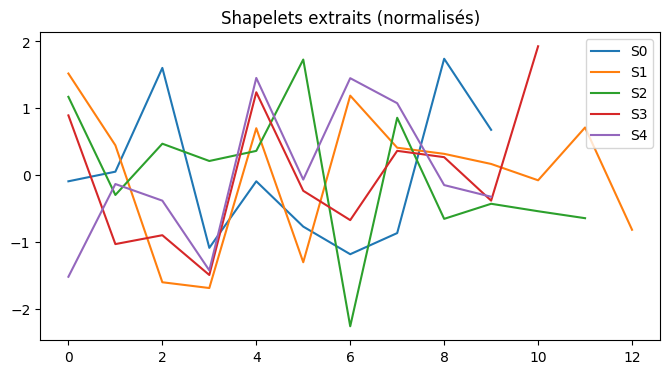

In [24]:
k_shapelets = ShapeletCachedSelection(
    T=X,
    y=y,
    min_len=10,
    max_len=20,
    k=5,
    quality_method="f_stat"
)

print("Shapelets sélectionnés :")
for s in k_shapelets:
    print(
        f"series={s.series_id}, start={s.start}, "
        f"len={s.length}, quality={s.quality:.3f}"
    )

    
plt.figure(figsize=(8, 4))
for i, s in enumerate(k_shapelets):
    plt.plot(z_normalize(s.data), label=f"S{i}")
plt.title("Shapelets extraits (normalisés)")
plt.legend()
plt.show()


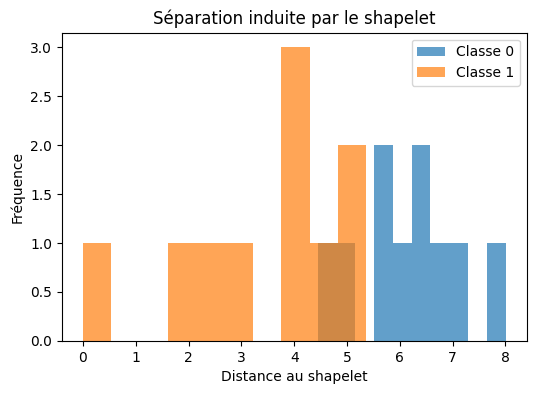

In [25]:
best_shapelet = k_shapelets[0]
D = findDistances(X, best_shapelet.data)
plt.figure(figsize=(6, 4))
plt.hist(D[y == 0], bins=10, alpha=0.7, label="Classe 0")
plt.hist(D[y == 1], bins=10, alpha=0.7, label="Classe 1")
plt.xlabel("Distance au shapelet")
plt.ylabel("Fréquence")
plt.title("Séparation induite par le shapelet")
plt.legend()
plt.show()


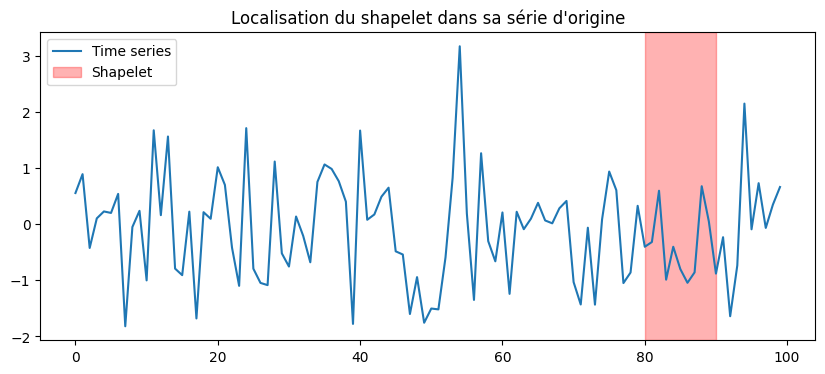

In [26]:
s = best_shapelet
t = X[s.series_id]

plt.figure(figsize=(10, 4))
plt.plot(t, label="Time series")
plt.axvspan(
    s.start,
    s.start + s.length,
    color="red",
    alpha=0.3,
    label="Shapelet"
)
plt.legend()
plt.title("Localisation du shapelet dans sa série d'origine")
plt.show()
